### Data processing...

In [ ]:
filename = './data/newswire.txt'

In [ ]:
# Splitting the texts in to train and tests.

lines_per_file = 6000
smallfile = None
with open(filename) as bigfile:
    for lineno, line in enumerate(bigfile):
        if lineno % lines_per_file == 0:
            if smallfile:
                smallfile.close()
            small_filename = f'file_{lineno}.txt'
            smallfile = open(small_filename, "w")
        smallfile.write(line)
    if smallfile:
        smallfile.close()

### Dependencies and imports

In [ ]:
!pip install -q transformers tokenizers datasets jax jaxlib flax

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 72.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 103.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.2/214.2 KB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 63.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.9/154.9 KB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 107.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.7/238.7 KB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from transformers import AutoTokenizer, FlaxAutoModelForCausalLM, pipeline, AutoModelForCausalLM
from datasets import load_dataset
import re

In [ ]:
# Name of the model. More models can be found here: https://huggingface.co/models

model_name = "flax-community/Sinhala-gpt2"
block_size = 128

### Loading the tokenizer..

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=block_size)

In [ ]:
# Adding special tokens to the tokenizer.

special_tokens_dict = {'bos_token': '<BOS>', 'eos_token': '<EOS>', 'pad_token': '<PAD>'}
num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)

### Loading the model from Huggingface for finetuning.

In [ ]:
model = AutoModelForCausalLM.from_pretrained(model_name, pad_token_id=tokenizer.eos_token_id)

In [ ]:
model.resize_token_embeddings(len(tokenizer))

Embedding(50269, 768)

### Creating the dataset from the the txt files we created.

In [ ]:
dataset = load_dataset('text', data_files={'train': 'file_0.txt', 'test': 'file_6000.txt'})

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset text downloaded and prepared to /root/.cache/huggingface/datasets/text/default-27354a8a647c3811/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

### Helper functions for tokenizing and cleaning the dataset

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"])

In [ ]:
def clean_function(examples):
  examples["text"] = re.sub('[\<\>\»\|\🕔\◂\▸\෴]', '', examples["text"])
  examples["text"] = re.sub('[a-zA-Z]+', '', examples["text"])
  examples["text"] = re.sub('[\t\n]', ' ', examples["text"])
  examples["text"] = re.sub('[\,\/\?\.\!\-\;\:\"\“\%\‘\”\�\_]{2,}', ' ', examples["text"])
  examples["text"] = re.sub('[\s]{2,}', ' ', examples["text"])
  return examples

In [ ]:
cleaned_datasets = dataset.map(clean_function, num_proc=4)

Map (num_proc=4):   0%|          | 0/6000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1783 [00:00<?, ? examples/s]

In [ ]:
tokenized_datasets = cleaned_datasets.map(tokenize_function, batched=True, num_proc=4, remove_columns=["text"])

Map (num_proc=4):   0%|          | 0/6000 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (149 > 128). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1348 > 128). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (476 > 128). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (651 > 128). Running this sequence through the model will result in indexing errors


Map (num_proc=4):   0%|          | 0/1783 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (420 > 128). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (628 > 128). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (497 > 128). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (628 > 128). Running this sequence through the model will result in indexing errors


### Let's look at an example from the dataset.

In [ ]:
print(tokenized_datasets["train"][1]["input_ids"], '\n',cleaned_datasets["train"][1])

[309, 297, 270, 288, 307, 310, 275, 268, 281, 297, 270, 288, 425, 264, 638, 264, 305, 268, 446, 277, 285, 265, 271, 265, 705, 285, 272, 279, 272, 301, 272, 355, 272, 300, 297, 270, 268, 266, 264, 280, 264, 578, 264, 3169, 264, 1073, 281, 296, 267, 265, 305, 264, 408, 872, 283, 515, 1612, 813, 268, 741, 283, 288, 331, 265, 365, 1243, 272, 270, 272, 283, 288, 299, 265, 304, 276, 333, 341, 581, 310, 1447, 264, 271, 286, 310, 339, 268, 360, 295, 265, 956, 268, 1679, 265, 286, 265, 269, 441, 285, 284, 274, 265, 301, 265, 370, 297, 270, 288, 307, 310, 275, 268, 638, 264, 305, 268, 446, 354, 285, 272, 279, 272, 301, 272, 281, 268, 270, 264, 269, 858, 264, 1048, 287, 277, 369, 283, 265, 280, 295, 265, 270, 308, 313, 268, 3575, 311, 296, 274, 272, 281, 296, 280, 299, 265, 304, 276, 333, 341, 266, 284, 335, 294, 284, 266, 272, 274, 264, 294, 276, 266, 299, 272, 270, 272, 281, 297, 270, 288, 1609, 265, 266, 264, 280, 354, 285, 272, 279, 272, 301, 272, 281, 268, 270, 264, 269, 858, 264, 2432, 286,

In [ ]:
print(tokenized_datasets["train"][1])

{'input_ids': [309, 297, 270, 288, 307, 310, 275, 268, 281, 297, 270, 288, 425, 264, 638, 264, 305, 268, 446, 277, 285, 265, 271, 265, 705, 285, 272, 279, 272, 301, 272, 355, 272, 300, 297, 270, 268, 266, 264, 280, 264, 578, 264, 3169, 264, 1073, 281, 296, 267, 265, 305, 264, 408, 872, 283, 515, 1612, 813, 268, 741, 283, 288, 331, 265, 365, 1243, 272, 270, 272, 283, 288, 299, 265, 304, 276, 333, 341, 581, 310, 1447, 264, 271, 286, 310, 339, 268, 360, 295, 265, 956, 268, 1679, 265, 286, 265, 269, 441, 285, 284, 274, 265, 301, 265, 370, 297, 270, 288, 307, 310, 275, 268, 638, 264, 305, 268, 446, 354, 285, 272, 279, 272, 301, 272, 281, 268, 270, 264, 269, 858, 264, 1048, 287, 277, 369, 283, 265, 280, 295, 265, 270, 308, 313, 268, 3575, 311, 296, 274, 272, 281, 296, 280, 299, 265, 304, 276, 333, 341, 266, 284, 335, 294, 284, 266, 272, 274, 264, 294, 276, 266, 299, 272, 270, 272, 281, 297, 270, 288, 1609, 265, 266, 264, 280, 354, 285, 272, 279, 272, 301, 272, 281, 268, 270, 264, 269, 858, 2

In [ ]:
# block_size == model_max_length
tokenizer.model_max_length

128

In [ ]:
def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    total_length = (total_length // block_size) * block_size
    # Split by chunks of max_len.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

In [ ]:
lm_datasets = tokenized_datasets.map(
    group_texts,
    batched=True,
    batch_size=1000,
    num_proc=4,
)

Map (num_proc=4):   0%|          | 0/6000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1783 [00:00<?, ? examples/s]

In [ ]:
tokenizer.decode(lm_datasets["train"][1]["input_ids"])

' ක්\u200dරීඩකයින් සංඛ්\u200dයාව 40 ක් බවයි අමාත්\u200dයවරයා එහිදී සඳහන් කළේ. දිගුකාලීන සැලසුමක් නොතිබීම හේතුවෙන් මෙරට ක්\u200dරිකට් ක්\u200dරිඩාව කඩා වැටී ඇති බව ක්\u200dරීඩා අමාත්\u200dය නාමල් රාජපක්ෂ පාර්ලිමේන්තුවේදී අද පැ'

In [ ]:
tokenizer.decode(lm_datasets["test"][10]["input_ids"])

' හට මෙවර නව කැබිනට් අමාත්\u200dය මණ්ඩලයේ හෝ රාජ්\u200dය අමාත්\u200dයධුරයන් හිමි නොවීම සුවිශේෂී සිදුවීමක් වනවා.එලෙස අමාත්\u200dයධුරයන් හිමි නොවූ පාර්ලිමේන්තුවේ ජේෂ්ඨ මන්ත්\u200dරීවරුන් පහතින් දැක්වෙනවා :1.මෛත'

### Configs and training the model. More info: https://huggingface.co/docs/transformers/main_classes/trainer

In [ ]:
from transformers import Trainer, TrainingArguments

In [ ]:
training_args = TrainingArguments(
    "test-clm",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    #push_to_hub=False,
    #push_to_hub_model_id="keshan/sinhala-gpt2-finetuned-newswire",
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=lm_datasets["train"],
    eval_dataset=lm_datasets["test"],
)

In [ ]:
import torch

torch.cuda.empty_cache()

In [ ]:
trainer.train()

### Calculating perplexity.

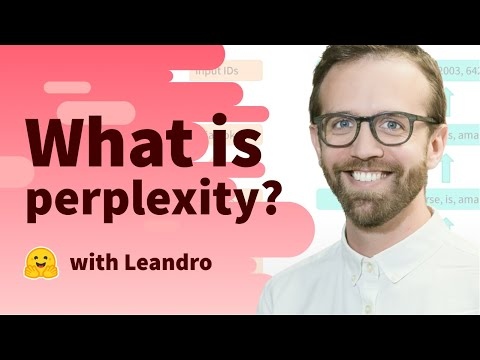

In [5]:
from IPython.lib.display import YouTubeVideo
YouTubeVideo('NURcDHhYe98', width=600, height=450)
# Youtube video explaining perplexity

In [ ]:
import math
eval_results = trainer.evaluate()
print(f"Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

Epoch,Training Loss,Validation Loss
0,1.177100,1.101600


Perplexity: 3.01


### Let's try some examples...

In [ ]:
generator = pipeline('text-generation', model=model, tokenizer=tokenizer)
generator("මම තමයි", max_length=100, num_return_sequences=5)

/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1201: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(


[{'generated_text': 'මම තමයි මගේ හිතේ මේ සෙල්ලම් කරන්නේ “ ඒ වෙලාවට මට මගේ ඉස්සරහපිටම හිතෙන්නේ මගේ හිතේ ඉන්න කෙනෙක් මේ සෙල්ලමට අහුවෙන්න තරම් වුණොත් ඒ සෙල්ලම් කරන්න මගේ ගෙදරට, යාල'},
 {'generated_text': 'මම තමයි හිස්වු කොන්ග්\u200dරස් මන්ත්\u200dරී ධුරට තේරී තිබෙන්නේ. ඉන්පසුව ජාතික ලැයිස්තු මන්ත්\u200dරී ධූරයට නැවතත් හිස්වූ මන්ත්\u200dරීවරයාව පත් වුණා. ඒ නිසා ඒ සියල්'},
 {'generated_text': 'මම තමයි සිරකරුවන් නිදහස් කරන්න තීරණය කළේ.මේක කෘතිමව අරගෙන අත්සන් කරපු දෙයක්. ඒක ඇතුළෙත් ඒ කොන්දේසිය තිබුණා. ඒ වුණත් මෙතෙක් කල් සෞඛ්\u200dයාරක්ෂිත පුරුද්ද ඒ විද'},
 {'generated_text': 'මම තමයි හැම පක්ෂයකම අය එකතුවෙලා අපි දියුණුවේ මාවතට යොමුවෙමින් සිටින්නේ. ජීවන වියදම් විවාදය කියන්නේ කුමක්ද කියලා අද ජනතාව අවබෝධ කරගෙන අවසන්” යැයි හේලරතන හිමියෝ ප'},
 {'generated_text': 'මම තමයි මැරවින්ලාගේ ආණ්ඩුවෙන් ජනාදිපති වික්\u200dරමසිංහලාට ගෑට ගැසුවේ.අපේ ආණ්ඩුවට තිබුණේ මොහොන්ලාගේ වෙල්ගමගේ සල්ලි තමයි ඒ. එයාගේම පුතාගේ ආණ්ඩුවක්. එය'}]

In [ ]:
generator("රට රකින විරුවා", max_length=250, num_return_sequences=5)

[{'generated_text': 'රට රකින විරුවා වැටුප් ප්\u200dරශ්නේ විසදන්ට මේ පාරවත් අවස්තාව දෙන්ට ඔනේ.මේ ආණ්ඩුව මේ තැනට ආවේ වෙන කිසිම දෙයකින් නෙමේ.සියලු පියවරයන් අරගෙන.නමුත් මේ ආණ්ඩුව ඒ වගේ දේවල් කරන්නේ නැහැ.ලංකාවේ ජාතිකවාදීන් හොදින් දන්නවා මුහුද ගොඩගැලීම වෙලාවේ මුහුදු ජලය වේගයෙන් කරදිය වෙරළට ආවා. ඒ නිසා මුහුද මැදින් වේගයෙන් ඉදිවෙමින් තිබුනු මුහුද ගිණිගන්නවා කියන සංඥාව දැක්කා.ඔව්. ලංකාව'},
 {'generated_text': 'රට රකින විරුවාද සෑමදාම අපට හමුවන රිලවුන් මෙන්ද අලින් නොව සිවුපයින් වනු ඇත.නමුත් අප මාර්ග සංවර්ධන අධිකාරිය සමග නිල ඇදුම් අදින නිලධාරියෙකුගේ වීඩියෝවක් පහත සබැදියාවෙන් උපුටා ගන්නා ලදී. දෙවැනි ලෝක යුද්ධයෙන් බ්\u200dරිතාන්\u200dයයට යටත්වී මිනිස් ජීවිත 1200ක් පමණ විනාශ වූ මොහුගේ නිවස ආසන්නයේ පිහිටි සොහොන් බිමක් පිළිබඳව බලධාරීන් අවධානයෙන් පසුවන බවයි වාර්තා වුණේ.එම සොහොන් බිම වෙ'},
 {'generated_text': 'රට රකින විරුවාණන්ගේ පුතා වෙමින් ඔවුන්ද කැටිව නැවත එම සංස්ථාවේ සභාපතිකම් වලට පත් කිරීමේ කාර්ය භාරය භාරගනු ලබන්නේ අම්පාරේ මුලතිව් ප්\u200dරදේශයෙන් කෙනෙකු බවද ඔවුන්ට නාමල් නමින් පුතෙක් සිටින බවද වාර්ත